### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [32]:
# libraries
import os
import sys
import platform
print(sys.version)

in_colab = 'google.colab' in sys.modules
strong_pc = platform.system() == 'Linux'

if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
#df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'Data', 'ESC-10-depth')
samplerate = 44100

3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
TensorFlow version: 2.11.1
keras version = 2.11.0


2023-08-28 02:08:15.589640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:15.590426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:15.591230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:15.591849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


# 3 UNSUPERVISED LEARNING: AUTOENCODERS

In [33]:
strong_pc = True

In [34]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

## 3.4 Autoencoder on preprocessed audio - Fully Convolutional AE

Again, we'll train the autoencoder only to reconstruct MFCC or STFT audio, not the one preprocessed by MEL.

### Create the dataset

The dataset is not changed from before.

In [35]:
preprocessing = 'STFT'
AE_name = 'Fully_Convolutional_AE_'+preprocessing
train, val, test, INPUT_DIM =  create_US_dataset(folder_number=1, preprocessing = 'STFT', main_dir = main_dir)

Creating the dataset from folder 01


2023-08-28 02:08:19.657394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:19.659614: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:19.671733: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:19.687439: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:19.689109: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:19.690307: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:19.691257: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:19.702150: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:19.704219: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:19

In [36]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [AE_name +'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created Fully_Convolutional_AE_STFT_count.txt with content '0' in folder Saved_Models


### Preparation to use Keras-Tuner

This time the convolutional autoencoder builder have a code with more than 1 dimenision.

In [37]:
#FULLY CONVOLUTIONAL AUTOENCODER

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_channels = 3, # no more than 3 to be able to plot the code
                      activation = 'tanh',
                      n_layers = 2, #no more thank 4
                      n_units = 32,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name,
                      ):
    lr = learning_rate

    #check the number of layers
    if n_layers > 4:
        print('The number of layers is too high, it has been set to 4')
        n_layers = 4

    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))

    output_padding_list = []
    lambda_padding_list = []

    for i in range(n_layers):
        filters = n_units * (i+1) if i<n_layers-1 else code_channels
        encoder.add(layers.Conv2D(filters, kernel_size,strides = strides, activation = activation, padding='valid'))

        #save the conv2dtranspose padding for the decoder
        _,width,height,_ = encoder.layers[-1].input_shape
        pad = (width-(((width - kernel_size[0])//strides[0])*strides[0]+kernel_size[0]), height-(((height - kernel_size[1])//strides[1])*strides[1]+kernel_size[1]))
        output_padding_list.append( pad )

        encoder.add(layers.MaxPool2D(max_pooling, padding='valid'))

        #save the upsampling padding for the decoder
        _,width,height,_ = encoder.layers[-1].input_shape
        lambda_padding_list.append((width%max_pooling[0], height%max_pooling[1]))

        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    #check if the code size is reasonable small
    code_prod = np.prod(encoder.layers[-1].output_shape[1:])
    inp_prod = np.prod(INPUT_DIM)
    if code_prod > inp_prod/10:
        print('The input has dimension', np.prod(INPUT_DIM))
        print('The code size (flattened) is', np.prod(encoder.layers[-1].output_shape[1:]))
        print('We must decrease the number of channels at least to ', int(inp_prod/10*code_channels/code_prod))
        #show the input params
        print('The input params are:')
        print(f'code_channels = {code_channels}')
        print(f'n_layers = {n_layers}')
        print(f'n_units = {n_units}')
        print(f'kernel_size = {kernel_size}')
        print(f'strides = {strides}')
        print(f'max_pooling = {max_pooling}')



    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(shape = encoder.layers[-1].output_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):

        decoder.add(layers.UpSampling2D(size=max_pooling))
        pad = lambda_padding_list[-i-1]
        decoder.add(layers.Lambda(lambda x: tf.pad(x, [[0,0],[0,pad[0]],[0,pad[1]], [0,0]])))

        filters = n_units * (n_layers-i-1) if i<n_layers-1 else img_shape[-1]
        pad =  output_padding_list[-i-1]
        decoder.add(
            layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, output_padding=pad)
        )

        if batch_norm:
            decoder.add(layers.BatchNormalization())
        if drop_out>0:
            decoder.add(layers.Dropout(drop_out))

    #resizing if needed
    if decoder.layers[-1].output_shape[1:] != INPUT_DIM:
        decoder.add(tf.keras.layers.Resizing(height = img_shape[0], width = img_shape[1], interpolation="bilinear", crop_to_aspect_ratio=False))


    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [38]:
verbose = 2
#test the build_autoencoder function
autoencoder = build_autoencoder(n_layers = 2, strides = (1,1), max_pooling = (2,2), code_channels = 1)
if verbose > 1 and autoencoder is not None:
    autoencoder.summary(line_length=100)
    autoencoder.layers[1].summary(line_length=100)
    autoencoder.layers[2].summary(line_length=100)

Model built with 1350 trainable params
Model: "Fully_Convolutional_AE_STFT"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_53 (InputLayer)                       [(None, 64, 128, 1)]                    0              
                                                                                                    
 Encoder (Sequential)                        (None, 14, 30, 1)                       741            
                                                                                                    
 Decoder (Sequential)                        (None, 64, 128, 1)                      741            
                                                                                                    
Total params: 1,482
Trainable params: 1,350
Non-trainable params: 132
______________________________________________

2023-08-28 02:08:22.137115: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:22.138313: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:22.139764: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:22.140842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:22.141588: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:22.142240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:22.142885: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:22.143553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:22.144533: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:22

In [39]:
# function to build the model using different hyperparameters (keras tuner code)
def build_model(hp):

    n_units = hp.Choice(name = 'n_units', values =  [4,8,16,32,64,128], default = 32)
    n_layers = hp.Int(name = 'n_layers', min_value = 1, max_value = 4, step=1, sampling='linear', default = 2)
    kernel_size = hp.Choice(name = 'kernel_size', values = [3,5,7], default = 3)
    strides = hp.Choice(name = 'strides', values = [2,3], default = 2)
    max_pooling = hp.Choice(name = 'max_pooling' , values = [2,3,4], default = 2)
    code_channels= hp.Int(name = 'code_channels', min_value = 1, max_value = 6, step = 1, sampling = 'linear', default = 3)
    activation = hp.Choice(name = 'activation', values = ['relu','elu','tanh'], default = 'tanh')
    drop_out = hp.Choice(name = 'drop_out', values = [0.0, 0.25, 0.5], default = 0.0)
    batch_norm = hp.Choice(name = 'batch_norm', values = [True, False], default = True)
    learning_rate= hp.Choice('learning_rate', values = [1e-4, 1e-3, 5*1e-3, 1e-2,5*1e-2,1e-1], default = 1e-3)


    model = build_autoencoder(code_channels = code_channels,
                              activation = activation,
                              n_layers = n_layers,
                              n_units = n_units,
                              kernel_size = (kernel_size,kernel_size),
                              strides = (strides,strides),
                              max_pooling = (max_pooling, max_pooling),
                              batch_norm = batch_norm,
                              drop_out = drop_out,
                              learning_rate= learning_rate)

    return model


In [40]:
#test the build_model function
build_model(kt.HyperParameters()).summary()

Model built with 2508 trainable params
Model: "Fully_Convolutional_AE_STFT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 3, 7, 3)           1327      
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        1317      
                                                                 
Total params: 2,644
Trainable params: 2,508
Non-trainable params: 136
_________________________________________________________________


2023-08-28 02:08:24.274170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:24.274887: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:24.275840: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:24.276484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


### Implement the grid search hyperparamter-wise

In [26]:
# dictionary with the default values of the hyperparams to be update each time
default_values = {
    'n_layers': 2,
    'n_units': 3,
    'kernel_size': 3,
    'strides':2,
    'max_pooling':2,
    'code_channels':3,
    'activation':'tanh',
    'drop_out':0.0,
    'batch_norm':True,
    'learning_rate':1e-3
}

key_list = list(default_values.keys())

#define the general variables for our tuner
hpo_methods = ['RandomSearch', 'BayesianOptimization','Hyperband']
max_model_size = 10**7
max_trials = 100
dir_name = AE_name
verbose=0

if strong_pc:
    train_small = train
    val_small = val
else:       
    small_size_dataset = 40
    train_val_small = train.unbatch().take(small_size_dataset)
    train_small = train_val_small.skip(10).batch(25) 
    val_small = train_val_small.take(10).batch(25)

# define a list to collect all the best scores
best_score_dict ={
    'RandomSearch': [],
    'BayesianOptimization': [],
    'Hyperband': []
}

folder_to_delete = []

for hpo_method in hpo_methods:
    random.shuffle(key_list)
    for hyper_params in key_list:
        print(f'Searching for the best value for {hyper_params}')

        #define an hp set with all fix but one
        hp = kt.HyperParameters()

        for fixed_param in default_values.keys():
            if fixed_param != hyper_params:
                hp.Fixed(name = fixed_param, value = default_values[fixed_param])

        if verbose>1:
            display(hp.space)

        #create a tuner for the params not fixed
        tuner = build_tuner(build_model = build_model,
                            hpo_method = hpo_method,
                            max_model_size = max_model_size,
                            max_trials = max_trials,
                            dir_name = dir_name,
                            overwrite = True,
                            objective = kt.Objective('val_mse', direction='min'),
                            hp=hp,
                            not_fixed_param = hyper_params,
                            tune_new_entries=True
                            )

        if verbose>2:
            display(tuner.search_space_summary(extended = True))

        #fit the tuner
        epochs = 50
        patience = 10
        metrics = ['mse']
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                    verbose=verbose,
                                                    patience=patience)]

        tuner.search(train_small, validation_data = val_small,
                            callbacks=callbacks,
                            epochs=epochs,
                            verbose=int(verbose>0),
                    )

        #retrive the best value for the free hp
        best_value = tuner.get_best_hyperparameters()[0].values[hyper_params]

        #retrive the best score reached
        best_score = tuner.get_best_models(num_models=1)[0].evaluate(val, return_dict = True)['mse']

        print(f'The best value for {hyper_params} is {best_value}, the best score is {best_score}')
        best_score_dict[hpo_method].append(best_score)

        #update the default dict of values
        default_values[hyper_params] = best_value

        #save the updated dictionary
        file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
        with open(file_path, 'wb') as file:
            pickle.dump(default_values, file)

        #delete the folder just created by the run
        folder_to_delete.append(os.path.join(main_dir,dir_name, hpo_method+'_'+hyper_params))

    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)

    display(best_params)

#save the best_score_dict
file_path = os.path.join(main_dir, dir_name, 'best_scores')
with open(file_path, 'wb') as file:
    pickle.dump(best_score_dict, file)

with open(file_path, 'rb') as file:
    best_scores = pickle.load(file)

display(best_scores)

for folder in folder_to_delete:
    shutil.rmtree(folder)


Searching for the best value for n_layers
Using Random Search strategy for HPO
Model built with 246 trainable params
The input has dimension 8192
The code size (flattened) is 1395
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 1
n_units = 3
kernel_size = (3, 3)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 66 trainable params
Model built with 246 trainable params
INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/

Model built with 246 trainable params
2/2 [==============================] - 0s 12ms/step - loss: 0.1456 - mse: 0.1456
The best value for n_layers is 2, the best score is 0.14559097588062286
Searching for the best value for batch_norm
Using Random Search strategy for HPO
Model built with 246 trainable params
Model built with 246 trainable params
Model built with 226 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 226 trainable params
2/2 [==============================] - 0s 13ms/step - loss: 0.0621 - mse: 0.0621
The best value for batch_norm is 0, the best score is 0.062149617820978165
Searching for the best value for kernel_size
Using Random Search strategy for HPO
Model built with 226 trainable params
Model built with 226 trainable params
Model built with 610 trainable params


2023-08-27 19:00:11.403805: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,74,138,1] vs. [128,64,128,1]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287

Model built with 1186 trainable params
INFO:tensorflow:Oracle triggered exit


2023-08-27 19:00:12.088836: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,64,128,1] vs. [128,72,136,1]
	 [[{{node mean_squared_error/SquaredDifference}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
   

Model built with 226 trainable params
2/2 [==============================] - 0s 12ms/step - loss: 0.0642 - mse: 0.0642
The best value for kernel_size is 3, the best score is 0.0641651600599289
Searching for the best value for max_pooling
Using Random Search strategy for HPO
Model built with 226 trainable params
Model built with 226 trainable params
Model built with 226 trainable params
INFO:tensorflow:Oracle triggered exit


2023-08-27 19:00:32.773899: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,64,130,1] vs. [128,64,128,1]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287

Model built with 226 trainable params
2/2 [==============================] - 0s 11ms/step - loss: 0.0608 - mse: 0.0608
The best value for max_pooling is 2, the best score is 0.06075839325785637
Searching for the best value for n_units
Using Random Search strategy for HPO
Model built with 2372 trainable params
Model built with 596 trainable params
Model built with 1188 trainable params
Model built with 2372 trainable params
Model built with 300 trainable params
Model built with 4740 trainable params
Model built with 9476 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 9476 trainable params
2/2 [==============================] - 0s 51ms/step - loss: 0.0480 - mse: 0.0480
The best value for n_units is 128, the best score is 0.04797165095806122
Searching for the best value for drop_out
Using Random Search strategy for HPO
Model built with 9476 trainable params
Model built with 9476 trainable params
Model built with 9476 trainable params
Model built with 9476 trainabl

2023-08-27 19:25:47.500081: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,64,152,1] vs. [128,64,128,1]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287

Model built with 16391 trainable params
2/2 [==============================] - 0s 56ms/step - loss: 0.0467 - mse: 0.0467
The best value for strides is 2, the best score is 0.046734802424907684
Searching for the best value for learning_rate
Using Random Search strategy for HPO
Model built with 16391 trainable params
Model built with 16391 trainable params
Model built with 16391 trainable params
Model built with 16391 trainable params
Model built with 16391 trainable params
Model built with 16391 trainable params
Model built with 16391 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 16391 trainable params
2/2 [==============================] - 0s 49ms/step - loss: 0.0363 - mse: 0.0363
The best value for learning_rate is 0.005, the best score is 0.03631806746125221
Searching for the best value for activation
Using Random Search strategy for HPO
Model built with 16391 trainable params
Model built with 16391 trainable params
Model built with 16391 trainable params
Mo

{'n_layers': 2,
 'n_units': 128,
 'kernel_size': 3,
 'strides': 2,
 'max_pooling': 2,
 'code_channels': 6,
 'activation': 'elu',
 'drop_out': 0.0,
 'batch_norm': 0,
 'learning_rate': 0.005}

Searching for the best value for code_channels
Using Bayesian Optimization strategy for HPO
Model built with 9476 trainable params
Model built with 7171 trainable params
Model built with 9476 trainable params
Model built with 11781 trainable params
Model built with 4866 trainable params
Model built with 14086 trainable params
Model built with 16391 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 14086 trainable params
2/2 [==============================] - 0s 58ms/step - loss: 0.0213 - mse: 0.0213
The best value for code_channels is 5, the best score is 0.021281970664858818
Searching for the best value for batch_norm
Using Bayesian Optimization strategy for HPO
Model built with 14610 trainable params
Model built with 14610 trainable params
Model built with 14086 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 14610 trainable params
2/2 [==============================] - 1s 66ms/step - loss: 0.0135 - mse: 0.0135
The best value for batch_no

Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
            ^^^^^^^^^^^^^^^^^^^
  File "/

The input has dimension 8192
The code size (flattened) is 2325
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 128
kernel_size = (3, 3)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 108 trainable params
2/2 [==============================] - 0s 13ms/step - loss: 0.0107 - mse: 0.0107
The best value for n_layers is 1, the best score is 0.010652109049260616
Searching for the best value for drop_out
Using Bayesian Optimization strategy for HPO
The input has dimension 8192
The code size (flattened) is 2325
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 128
kernel_size = (3, 3)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 108 trainable params
The input has dimension 8192
The code size (flattened) is 2325
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 128
kernel_siz

2023-08-27 20:08:34.305608: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,64,128,1] vs. [128,64,134,1]
	 [[{{node mean_squared_error/SquaredDifference}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
   

The input has dimension 8192
The code size (flattened) is 2325
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 128
kernel_size = (3, 3)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 108 trainable params
2/2 [==============================] - 0s 12ms/step - loss: 0.0145 - mse: 0.0145
The best value for strides is 2, the best score is 0.014462283812463284
Searching for the best value for kernel_size
Using Bayesian Optimization strategy for HPO
The input has dimension 8192
The code size (flattened) is 2325
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 128
kernel_size = (3, 3)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 108 trainable params
The input has dimension 8192
The code size (flattened) is 2325
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 128
kernel_s

2023-08-27 20:09:09.213897: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,66,130,1] vs. [128,64,128,1]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287

The input has dimension 8192
The code size (flattened) is 2100
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 128
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 508 trainable params
INFO:tensorflow:Oracle triggered exit
The input has dimension 8192
The code size (flattened) is 2100
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 128
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 508 trainable params
2/2 [==============================] - 0s 20ms/step - loss: 0.0067 - mse: 0.0067
The best value for kernel_size is 7, the best score is 0.006652801297605038
Searching for the best value for activation
Using Bayesian Optimization strategy for HPO
The input has dimension 8192
The code size (flattened) is 2100
We must decrease the number of channels at least to  1
The input params are:
code_channel

2023-08-27 20:19:14.221184: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,64,128,1] vs. [128,62,128,1]
	 [[{{node mean_squared_error/SquaredDifference}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
   

Model built with 508 trainable params
INFO:tensorflow:Oracle triggered exit
The input has dimension 8192
The code size (flattened) is 2100
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 128
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 508 trainable params
2/2 [==============================] - 0s 20ms/step - loss: 0.0075 - mse: 0.0075
The best value for max_pooling is 2, the best score is 0.007486728485673666
Searching for the best value for n_units
Using Bayesian Optimization strategy for HPO
The input has dimension 8192
The code size (flattened) is 2100
We must decrease the number of channels at least to  1
The input params are:
code_channels = 5
n_layers = 1
n_units = 32
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 508 trainable params
The input has dimension 8192
The code size (flattened) is 2100
We must decrease the number of channels at least to  1


{'n_layers': 1,
 'n_units': 8,
 'kernel_size': 7,
 'strides': 2,
 'max_pooling': 2,
 'code_channels': 5,
 'activation': 'relu',
 'drop_out': 0.0,
 'batch_norm': 1,
 'learning_rate': 0.01}

Searching for the best value for code_channels
Using Hyperband strategy for HPO
The input has dimension 8192
The code size (flattened) is 1260
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 1
n_units = 8
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 306 trainable params
The input has dimension 8192
The code size (flattened) is 840
We must decrease the number of channels at least to  1
The input params are:
code_channels = 2
n_layers = 1
n_units = 8
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 205 trainable params
The input has dimension 8192
The code size (flattened) is 1260
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 1
n_units = 8
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 306 trainable params
The input has dimension 8192
The code size (flattened) is 1680
We must decrease t

2023-08-27 20:26:27.267478: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,72,136,1] vs. [128,64,128,1]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/tuners/hyperband.py", line

INFO:tensorflow:Oracle triggered exit


Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^

The input has dimension 8192
The code size (flattened) is 1260
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 1
n_units = 64
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 306 trainable params
2/2 [==============================] - 0s 19ms/step - loss: 0.0459 - mse: 0.0459
The best value for n_layers is 1, the best score is 0.04587462544441223
Searching for the best value for drop_out
Using Hyperband strategy for HPO
The input has dimension 8192
The code size (flattened) is 1260
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 1
n_units = 64
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 306 trainable params
The input has dimension 8192
The code size (flattened) is 1260
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 1
n_units = 64
kernel_size = (7, 7)
strid

2023-08-27 20:26:41.792513: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,66,130,1] vs. [128,64,128,1]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/tuners/hyperband.py", line

The input has dimension 8192
The code size (flattened) is 1260
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 1
n_units = 64
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 306 trainable params
INFO:tensorflow:Oracle triggered exit
The input has dimension 8192
The code size (flattened) is 1260
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers = 1
n_units = 64
kernel_size = (7, 7)
strides = (2, 2)
max_pooling = (2, 2)
Model built with 306 trainable params
2/2 [==============================] - 0s 20ms/step - loss: 0.0410 - mse: 0.0410
The best value for kernel_size is 7, the best score is 0.04097888991236687
Searching for the best value for max_pooling
Using Hyperband strategy for HPO
The input has dimension 8192
The code size (flattened) is 1260
We must decrease the number of channels at least to  1
The input params are:
code_channels = 3
n_layers

2023-08-27 20:26:49.982974: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [128,62,128,1] vs. [128,64,128,1]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]]
Traceback (most recent call last):
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/keras_tuner/tuners/hyperband.py", line

Model built with 306 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 306 trainable params
2/2 [==============================] - 0s 20ms/step - loss: 0.0410 - mse: 0.0410
The best value for max_pooling is 4, the best score is 0.0409662090241909
Searching for the best value for strides
Using Hyperband strategy for HPO
Model built with 306 trainable params
Model built with 306 trainable params
Model built with 306 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 306 trainable params
2/2 [==============================] - 0s 12ms/step - loss: 0.0410 - mse: 0.0410
The best value for strides is 3, the best score is 0.04097721725702286
Searching for the best value for activation
Using Hyperband strategy for HPO
Model built with 306 trainable params
Model built with 306 trainable params
Model built with 306 trainable params
Model built with 306 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 306 trainable params
2/2 [=====

{'n_layers': 1,
 'n_units': 64,
 'kernel_size': 7,
 'strides': 3,
 'max_pooling': 4,
 'code_channels': 3,
 'activation': 'elu',
 'drop_out': 0.25,
 'batch_norm': 1,
 'learning_rate': 0.1}

{'RandomSearch': [0.14559097588062286,
  0.062149617820978165,
  0.0641651600599289,
  0.06075839325785637,
  0.04797165095806122,
  0.04774654284119606,
  0.04549286141991615,
  0.046734802424907684,
  0.03631806746125221,
  0.022332871332764626],
 'BayesianOptimization': [0.021281970664858818,
  0.013482089154422283,
  0.010652109049260616,
  0.006087672896683216,
  0.014462283812463284,
  0.006652801297605038,
  0.006222887896001339,
  0.006951751187443733,
  0.007486728485673666,
  0.0064633809961378574],
 'Hyperband': [0.27196672558784485,
  0.2859126031398773,
  0.2730955183506012,
  0.045933693647384644,
  0.04587462544441223,
  0.04105158522725105,
  0.04097888991236687,
  0.0409662090241909,
  0.04097721725702286,
  0.0407908633351326]}

In [27]:
# compare the best hp from the 3 grid search methods
hyperparamters = []
for hpo_method in  ['RandomSearch', 'BayesianOptimization','Hyperband']:
    file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
    with open(file_path, 'rb') as file:
        hyperparamters.append(pickle.load(file))
pd.DataFrame(hyperparamters, index = ['RandomSearch', 'BayesianOptimization','Hyperband'])

,n_layers,n_units,kernel_size,strides,max_pooling,code_channels,activation,drop_out,batch_norm,learning_rate
RandomSearch,2,128,3,2,2,6,elu,0.00,0,0.005
BayesianOptimization,1,8,7,2,2,5,relu,0.00,1,0.010
Hyperband,1,64,7,3,4,3,elu,0.25,1,0.100


### Train the model with best params on more data

In [41]:
insert_by_hand = True
dir_name = AE_name
if insert_by_hand:
    best_params = {
        'n_layers':2,
        'n_units':128,
        'kernel_size':(3,3),
        'strides':(2,2),
        'max_pooling':(2,2),5
        'code_channels':6,
        'activation':'elu',
        'drop_out':0,
        'batch_norm':True,
        'learning_rate':0.010,
    }
else:
    file_path = os.path.join(main_dir, dir_name, 'Hyperband'+'_best_params')
    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)
        for key_double in ['kernel_size','strides','max_pooling']:
            best_params[key_double] = (best_params[key_double],best_params[key_double])


# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
verbose=0
if verbose>0:
    autoencoder.summary()
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

epochs = 100
n_folders = 125 

US_training(AE_name = AE_name, 
            autoencoder = autoencoder, 
            epochs = epochs , 
            n_folders=n_folders, 
            preprocessing = preprocessing, 
            ndim=3,
            verbose = verbose)

2023-08-28 02:08:28.450836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:28.451789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:28.453150: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:28.454059: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:28.471849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:28.472575: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:28.473604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:28.474214: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:28.570586: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:28

Model built with 16917 trainable params
Last folder trained: 0
Creating the dataset from folder 01


2023-08-28 02:08:28.653715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:29.724160: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:31.810954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:31.811945: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:31.812543: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:31.826087: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:31.828228: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:31.833222: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:31.834996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:31

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


2023-08-28 02:08:37.935514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:37.936307: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:37.936902: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:37.937537: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:37.938158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:37.939193: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:37.939815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:37.940434: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:37.941225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:37

This model has a size of 0.25861358642578125 MB


2023-08-28 02:08:38.599038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:38.716807: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:38.723306: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:38.729247: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:38.737986: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:38.739767: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:38.767461: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:38.771793: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:38.776595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:38

Creating the dataset from folder 02


2023-08-28 02:08:39.752810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:40.385177: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:40.387003: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:40.391678: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:40.393348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:40.598391: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:40.663052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:40.665302: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:41.042255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:41

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 03


2023-08-28 02:08:47.660122: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:47.666374: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:47.672453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:47.680791: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:47.682513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:47.719918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:47.725068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:47.730778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:47.732719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:49

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 04


2023-08-28 02:08:56.407595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:56.413928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:56.421447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:56.433244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:56.435157: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:56.461915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:56.465273: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:56.469865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:56.471460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:08:57

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 05


2023-08-28 02:09:04.732590: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:04.741741: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:04.742836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:04.744076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:04.745873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:04.746591: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:04.747377: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:04.748199: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:04.751587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:04

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 06


2023-08-28 02:09:59.828607: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:59.832311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:59.835929: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:59.839048: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:59.842376: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:59.845453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:59.849430: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:59.852657: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:59.855681: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:09:59

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 07


2023-08-28 02:10:53.733642: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:10:53.737274: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:10:53.740716: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:10:53.743626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:10:53.746868: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:10:53.749930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:10:53.753076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:10:53.755883: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:10:53.758669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:10:53

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 08


2023-08-28 02:11:44.302363: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:11:44.306328: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:11:44.310012: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:11:44.312994: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:11:44.316310: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:11:44.319334: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:11:44.322601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:11:44.325656: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:11:44.329748: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:11:44

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 09


2023-08-28 02:12:35.738559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:12:35.742312: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:12:35.745870: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:12:35.748937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:12:35.752862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:12:35.756476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:12:35.759767: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:12:35.762661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:12:35.765647: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:12:35

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 10


2023-08-28 02:13:28.043628: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:13:28.047391: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:13:28.050878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:13:28.053801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:13:28.056974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:13:28.060302: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:13:28.063571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:13:28.066413: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:13:28.069225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:13:28

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 11


2023-08-28 02:14:18.962316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:14:18.965985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:14:18.969543: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:14:18.972489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:14:18.975619: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:14:18.978505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:14:18.981716: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:14:18.984627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:14:18.987539: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:14:18

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 12


2023-08-28 02:15:10.636219: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:15:10.639890: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:15:10.643375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:15:10.646293: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:15:10.649439: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:15:10.652756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:15:10.655987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:15:10.658809: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:15:10.661682: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:15:10

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 13


2023-08-28 02:16:00.863242: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:00.866900: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:00.870490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:00.873608: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:00.876851: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:00.879814: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:00.882957: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:00.885755: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:00.890309: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:00

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 14


2023-08-28 02:16:52.009160: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:52.013104: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:52.016806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:52.019974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:52.023329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:52.026510: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:52.030100: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:52.033192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:52.036176: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:16:52

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 15


2023-08-28 02:17:49.891082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:17:49.896604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:17:49.900369: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:17:49.904122: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:17:49.907722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:17:49.911329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:17:49.914652: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:17:49.917570: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:17:49.920427: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:17:49

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 16


2023-08-28 02:18:41.454497: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:18:41.458385: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:18:41.464411: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:18:41.467707: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:18:41.471432: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:18:41.474745: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:18:41.478189: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:18:41.481417: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:18:41.484585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:18:41

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 17


2023-08-28 02:19:33.146833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:19:33.150581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:19:33.154188: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:19:33.157181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:19:33.160393: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:19:33.163410: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:19:33.166630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:19:33.169562: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:19:33.172512: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:19:33

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 18


2023-08-28 02:20:28.561486: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:20:28.565838: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:20:28.569488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:20:28.572477: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:20:28.575853: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:20:28.579071: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:20:28.582520: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:20:28.585381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:20:28.588495: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:20:28

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 19


2023-08-28 02:21:20.514070: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:21:20.517860: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:21:20.522159: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:21:20.525404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:21:20.528793: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:21:20.531960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:21:20.535686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:21:20.539624: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:21:20.542835: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:21:20

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 20


2023-08-28 02:22:15.404221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:22:15.407954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:22:15.411543: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:22:15.415260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:22:15.418659: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:22:15.421705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:22:15.424877: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:22:15.427731: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:22:15.430998: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:22:15

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 21


2023-08-28 02:23:07.481924: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:23:07.485993: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:23:07.489867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:23:07.492930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:23:07.496123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:23:07.500260: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:23:07.503721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:23:07.506762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:23:07.509647: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:23:07

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 22


2023-08-28 02:24:00.749479: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:00.753551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:00.757335: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:00.760665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:00.764401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:00.767886: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:00.771454: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:00.774509: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:00.777618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:00

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 23


2023-08-28 02:24:53.019934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:53.023724: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:53.027320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:53.030337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:53.033620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:53.036735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:53.040002: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:53.042896: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:53.045788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:24:53

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 24


2023-08-28 02:25:45.129351: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:25:45.133232: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:25:45.137014: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:25:45.140444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:25:45.143986: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:25:45.147039: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:25:45.150331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:25:45.153236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:25:45.156389: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:25:45

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 25


2023-08-28 02:26:37.156128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:26:37.159794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:26:37.163384: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:26:37.166764: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:26:37.170043: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:26:37.173076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:26:37.176253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:26:37.179118: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:26:37.182324: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:26:37

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 26


2023-08-28 02:27:29.509428: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:27:29.513038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:27:29.516445: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:27:29.519348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:27:29.522559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:27:29.525601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:27:29.528755: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:27:29.531562: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:27:29.535694: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:27:29

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 27


2023-08-28 02:28:23.168653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:28:23.172587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:28:23.176290: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:28:23.179757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:28:23.183394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:28:23.186676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:28:23.190033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:28:23.193107: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:28:23.196382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:28:23

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 28


2023-08-28 02:29:15.694618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:29:15.698566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:29:15.703022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:29:15.707236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:29:15.711574: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:29:15.715763: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:29:15.720278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:29:15.724105: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:29:15.728253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:29:15

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 29


2023-08-28 02:30:10.063084: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:30:10.068233: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:30:10.071640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:30:10.074639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:30:10.078503: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:30:10.081595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:30:10.084720: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:30:10.087488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:30:10.090313: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:30:10

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 30


2023-08-28 02:31:05.512527: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:05.516557: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:05.520421: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:05.523997: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:05.527419: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:05.530544: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:05.533973: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:05.537308: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:05.541211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:05

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 31


2023-08-28 02:31:58.724044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:58.727737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:58.731570: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:58.734784: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:58.738030: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:58.741119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:58.744460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:58.747749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:58.750930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:31:58

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 32


2023-08-28 02:32:52.322682: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:32:52.326600: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:32:52.330360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:32:52.333509: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:32:52.337067: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:32:52.340320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:32:52.343927: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:32:52.347101: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:32:52.352673: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:32:52

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 33


2023-08-28 02:33:44.471654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:33:44.477860: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:33:44.483962: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:33:44.489174: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:33:44.493042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:33:44.496282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:33:44.499587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:33:44.502465: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:33:44.505331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:33:44

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 34


2023-08-28 02:34:36.539448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:34:36.543137: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:34:36.546663: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:34:36.549815: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:34:36.553054: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:34:36.556015: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:34:36.559139: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:34:36.561951: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:34:36.564894: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:34:36

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 35


2023-08-28 02:35:32.287098: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:35:32.290941: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:35:32.295337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:35:32.298732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:35:32.302265: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:35:32.305539: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:35:32.309193: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:35:32.313044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:35:32.316366: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:35:32

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 36


2023-08-28 02:36:26.481718: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:36:26.485749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:36:26.491127: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:36:26.494382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:36:26.497658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:36:26.500779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:36:26.504412: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:36:26.507637: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:36:26.510595: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:36:26

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 37


2023-08-28 02:37:19.564934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:37:19.568951: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:37:19.572536: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:37:19.575571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:37:19.579436: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:37:19.582810: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:37:19.586136: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:37:19.589016: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:37:19.591914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:37:19

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 38


2023-08-28 02:38:15.265525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:38:15.270875: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:38:15.275072: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:38:15.278337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:38:15.281803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:38:15.285060: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:38:15.288573: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:38:15.291719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:38:15.294845: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:38:15

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 39


2023-08-28 02:39:07.414519: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:39:07.418267: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:39:07.422241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:39:07.425403: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:39:07.428743: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:39:07.433233: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:39:07.436615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:39:07.439872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:39:07.442829: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:39:07

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 40


2023-08-28 02:40:00.092121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:00.095849: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:00.099498: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:00.102753: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:00.106127: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:00.109197: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:00.112407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:00.115384: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:00.118623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:00

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 41


2023-08-28 02:40:55.665161: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:55.669157: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:55.672776: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:55.676170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:55.680281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:55.684021: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:55.687743: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:55.690769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:55.693721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:40:55

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 42


2023-08-28 02:41:49.174540: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:41:49.180006: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:41:49.186873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:41:49.191622: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:41:49.195627: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:41:49.198769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:41:49.202062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:41:49.205321: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:41:49.208422: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:41:49

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 43


2023-08-28 02:42:44.173228: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:42:44.176916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:42:44.180487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:42:44.184491: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:42:44.189131: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:42:44.193164: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:42:44.196568: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:42:44.199550: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:42:44.202440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:42:44

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 44


2023-08-28 02:43:37.949221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:43:37.953080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:43:37.957179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:43:37.960653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:43:37.964178: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:43:37.967468: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:43:37.970882: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:43:37.974225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:43:37.977743: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:43:37

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 45


2023-08-28 02:44:31.513899: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:44:31.517833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:44:31.521447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:44:31.524457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:44:31.527751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:44:31.531018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:44:31.534402: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:44:31.537296: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:44:31.540180: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:44:31

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 46


2023-08-28 02:45:26.214857: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:45:26.218594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:45:26.222589: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:45:26.225920: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:45:26.229349: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:45:26.232476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:45:26.235862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:45:26.239157: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:45:26.244862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:45:26

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 47


2023-08-28 02:46:19.910228: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:46:19.913972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:46:19.918190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:46:19.921458: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:46:19.924756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:46:19.927772: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:46:19.931005: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:46:19.934259: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:46:19.937267: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:46:19

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 48


2023-08-28 02:47:12.910207: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:47:12.914059: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:47:12.917643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:47:12.920610: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:47:12.923937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:47:12.927149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:47:12.930437: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:47:12.933293: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:47:12.936148: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:47:12

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 49


2023-08-28 02:48:07.380199: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:48:07.385190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:48:07.390023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:48:07.393142: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:48:07.396399: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:48:07.399596: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:48:07.403015: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:48:07.406029: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:48:07.408915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:48:07

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 50


2023-08-28 02:49:01.659236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:01.663051: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:01.666699: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:01.669758: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:01.673022: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:01.676158: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:01.679460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:01.682397: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:01.685279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:01

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 51


2023-08-28 02:49:54.755214: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:54.759203: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:54.763503: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:54.766817: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:54.770371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:54.774719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:54.778276: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:54.781243: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:54.784249: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:49:54

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 52


2023-08-28 02:50:48.793099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:50:48.797001: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:50:48.800703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:50:48.803870: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:50:48.807307: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:50:48.810812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:50:48.814281: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:50:48.817349: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:50:48.820427: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:50:48

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 53


2023-08-28 02:51:47.889657: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:51:47.893622: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:51:47.897248: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:51:47.900289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:51:47.903518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:51:47.906551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:51:47.910210: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:51:47.913570: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:51:47.916934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:51:47

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 54


2023-08-28 02:52:44.204018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:52:44.207839: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:52:44.211432: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:52:44.214430: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:52:44.217738: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:52:44.220780: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:52:44.223976: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:52:44.226821: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:52:44.229662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:52:44

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 55


2023-08-28 02:53:39.490799: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:53:39.494639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:53:39.498786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:53:39.502142: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:53:39.505654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:53:39.508918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:53:39.512438: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:53:39.516344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:53:39.519572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:53:39

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 56


2023-08-28 02:54:33.129937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:54:33.133763: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:54:33.137494: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:54:33.141149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:54:33.144821: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:54:33.147953: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:54:33.151379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:54:33.154459: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:54:33.158495: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:54:33

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 57


2023-08-28 02:55:27.589493: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:55:27.593279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:55:27.596889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:55:27.600335: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:55:27.604003: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:55:27.607303: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:55:27.610531: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:55:27.613382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:55:27.616811: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:55:27

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 58


2023-08-28 02:56:22.838582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:56:22.842922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:56:22.846965: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:56:22.850348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:56:22.853907: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:56:22.857128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:56:22.860701: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:56:22.863807: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:56:22.867092: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:56:22

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 59


2023-08-28 02:57:19.044152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:57:19.049908: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:57:19.055414: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:57:19.060095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:57:19.064199: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:57:19.067581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:57:19.071471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:57:19.074705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:57:19.077728: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:57:19

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 60


2023-08-28 02:58:13.464389: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:58:13.468322: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:58:13.472093: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:58:13.475189: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:58:13.478623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:58:13.483178: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:58:13.486469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:58:13.489509: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:58:13.492759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:58:13

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 61


2023-08-28 02:59:11.485669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:59:11.491084: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:59:11.496332: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:59:11.500885: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:59:11.505673: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:59:11.509055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:59:11.512734: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:59:11.515858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:59:11.518955: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 02:59:11

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 62


2023-08-28 03:00:06.903956: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:00:06.907937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:00:06.911558: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:00:06.914570: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:00:06.917795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:00:06.920867: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:00:06.925006: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:00:06.928464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:00:06.931880: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:00:06

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 63


2023-08-28 03:01:01.843230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:01.846972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:01.852473: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:01.855560: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:01.858820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:01.861854: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:01.865388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:01.868415: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:01.871286: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:01

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 64


2023-08-28 03:01:58.286714: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:58.290622: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:58.294755: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:58.298346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:58.301952: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:58.305280: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:58.308808: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:58.312601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:58.316080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:01:58

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 65


2023-08-28 03:02:53.688782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:02:53.692900: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:02:53.696664: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:02:53.699789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:02:53.703120: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:02:53.706535: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:02:53.710033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:02:53.713053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:02:53.715991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:02:53

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 66


2023-08-28 03:03:48.365949: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:03:48.369783: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:03:48.374755: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:03:48.377852: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:03:48.381521: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:03:48.384759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:03:48.388238: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:03:48.391164: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:03:48.394034: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:03:48

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 67


2023-08-28 03:04:43.503104: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:04:43.507141: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:04:43.511255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:04:43.514655: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:04:43.518245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:04:43.521493: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:04:43.525195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:04:43.528788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:04:43.532076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:04:43

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 68


2023-08-28 03:05:37.507707: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:05:37.511880: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:05:37.515718: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:05:37.518934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:05:37.522347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:05:37.525584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:05:37.529142: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:05:37.532224: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:05:37.535211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:05:37

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 69


2023-08-28 03:06:31.179393: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:06:31.183614: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:06:31.189009: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:06:31.193103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:06:31.196772: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:06:31.199891: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:06:31.203082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:06:31.205934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:06:31.208906: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:06:31

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 70


2023-08-28 03:07:25.280209: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:07:25.284348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:07:25.288210: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:07:25.291421: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:07:25.294864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:07:25.298149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:07:25.301833: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:07:25.305004: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:07:25.309863: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:07:25

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 71


2023-08-28 03:08:19.461340: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:08:19.465238: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:08:19.468841: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:08:19.471825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:08:19.475040: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:08:19.478490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:08:19.481795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:08:19.484671: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:08:19.487502: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:08:19

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 72


2023-08-28 03:09:16.920556: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:09:16.924697: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:09:16.928430: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:09:16.931420: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:09:16.934634: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:09:16.937624: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:09:16.941044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:09:16.944439: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:09:16.947381: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:09:16

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 73


2023-08-28 03:10:12.610756: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:10:12.614576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:10:12.618295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:10:12.621665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:10:12.625205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:10:12.628476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:10:12.631846: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:10:12.634893: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:10:12.639983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:10:12

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 74


2023-08-28 03:11:08.766548: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:11:08.771947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:11:08.777304: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:11:08.781793: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:11:08.785614: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:11:08.788716: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:11:08.791994: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:11:08.794906: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:11:08.798049: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:11:08

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 75


2023-08-28 03:12:06.399587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:12:06.403373: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:12:06.407988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:12:06.411011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:12:06.414269: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:12:06.417684: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:12:06.421067: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:12:06.424013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:12:06.426889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:12:06

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 76


2023-08-28 03:13:05.121166: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:13:05.125062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:13:05.129167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:13:05.132379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:13:05.135770: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:13:05.138904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:13:05.142482: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:13:05.146346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:13:05.151721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:13:05

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 77


2023-08-28 03:14:01.662914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:01.666826: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:01.670584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:01.674018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:01.677615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:01.681106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:01.684513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:01.687447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:01.691636: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:01

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 78


2023-08-28 03:14:58.015118: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:58.019001: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:58.022558: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:58.025703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:58.028933: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:58.031900: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:58.035179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:58.038056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:58.040985: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:14:58

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 79


2023-08-28 03:15:55.157675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:15:55.161585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:15:55.167502: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:15:55.170940: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:15:55.174507: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:15:55.177841: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:15:55.181474: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:15:55.184681: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:15:55.187828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:15:55

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 80


2023-08-28 03:16:51.381092: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:16:51.384806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:16:51.388329: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:16:51.391282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:16:51.394441: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:16:51.397386: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:16:51.400565: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:16:51.403695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:16:51.407929: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:16:51

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 81


2023-08-28 03:17:50.746659: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:17:50.750533: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:17:50.754331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:17:50.757347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:17:50.760644: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:17:50.763729: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:17:50.767030: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:17:50.770113: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:17:50.773003: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:17:50

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 82


2023-08-28 03:18:48.131934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:18:48.135848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:18:48.139664: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:18:48.143128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:18:48.146641: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:18:48.149938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:18:48.153375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:18:48.156589: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:18:48.159971: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:18:48

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 83


2023-08-28 03:19:51.552948: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:19:51.556727: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:19:51.560390: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:19:51.563653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:19:51.566960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:19:51.570058: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:19:51.573278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:19:51.576172: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:19:51.580765: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:19:51

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 84


2023-08-28 03:20:54.146302: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:20:54.150462: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:20:54.154702: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:20:54.157871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:20:54.161163: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:20:54.164202: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:20:54.167959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:20:54.171375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:20:54.174344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:20:54

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 85


2023-08-28 03:21:53.778145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:21:53.782163: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:21:53.786097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:21:53.789265: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:21:53.792660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:21:53.795860: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:21:53.799471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:21:53.802665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:21:53.805729: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:21:53

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 86


2023-08-28 03:22:51.334438: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:22:51.338382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:22:51.343398: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:22:51.347669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:22:51.351879: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:22:51.355155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:22:51.358492: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:22:51.361375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:22:51.364866: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:22:51

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 87


2023-08-28 03:23:47.461121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:23:47.464841: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:23:47.468318: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:23:47.471234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:23:47.474704: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:23:47.477892: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:23:47.481152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:23:47.484050: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:23:47.487031: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:23:47

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 88


2023-08-28 03:24:44.215231: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:24:44.219057: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:24:44.222907: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:24:44.226103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:24:44.229713: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:24:44.233023: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:24:44.236529: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:24:44.239605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:24:44.242608: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:24:44

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 89


2023-08-28 03:25:45.505278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:25:45.509525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:25:45.513467: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:25:45.516662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:25:45.520097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:25:45.525237: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:25:45.528821: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:25:45.531965: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:25:45.534906: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:25:45

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 90


2023-08-28 03:26:45.203750: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:26:45.208383: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:26:45.212599: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:26:45.215935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:26:45.219824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:26:45.223866: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:26:45.227864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:26:45.231230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:26:45.234341: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:26:45

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 91


2023-08-28 03:27:44.725699: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:27:44.729802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:27:44.733517: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:27:44.736650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:27:44.740340: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:27:44.743757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:27:44.747407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:27:44.750499: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:27:44.753518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:27:44

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 92


2023-08-28 03:28:41.580303: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:28:41.584052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:28:41.589063: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:28:41.592444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:28:41.595733: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:28:41.598737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:28:41.601981: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:28:41.604857: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:28:41.607848: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:28:41

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 93


2023-08-28 03:29:37.074090: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:29:37.077969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:29:37.081604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:29:37.084582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:29:37.087806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:29:37.090828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:29:37.093989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:29:37.096804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:29:37.099636: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:29:37

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 94


2023-08-28 03:30:35.216146: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:30:35.220121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:30:35.223881: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:30:35.227191: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:30:35.230865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:30:35.234094: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:30:35.237695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:30:35.240787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:30:35.243966: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:30:35

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 95


2023-08-28 03:31:30.875553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:31:30.879490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:31:30.883413: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:31:30.886715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:31:30.890594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:31:30.894160: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:31:30.897571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:31:30.900779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:31:30.903749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:31:30

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 96


2023-08-28 03:32:28.932064: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:32:28.935933: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:32:28.939759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:32:28.942847: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:32:28.946171: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:32:28.949432: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:32:28.952726: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:32:28.955864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:32:28.958862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:32:28

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 97


2023-08-28 03:33:27.401190: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:33:27.405584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:33:27.409435: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:33:27.412844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:33:27.416489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:33:27.420043: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:33:27.423661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:33:27.426804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:33:27.430099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:33:27

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 98


2023-08-28 03:34:27.404742: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:34:27.408585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:34:27.412262: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:34:27.415451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:34:27.419001: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:34:27.423026: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:34:27.426490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:34:27.429448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:34:27.432325: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:34:27

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 99


2023-08-28 03:35:24.645674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:35:24.649394: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:35:24.652892: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:35:24.655787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:35:24.659154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:35:24.662334: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:35:24.665567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:35:24.668393: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:35:24.671186: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:35:24

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 100


2023-08-28 03:36:30.179342: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:36:30.183365: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:36:30.187120: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:36:30.190310: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:36:30.193788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:36:30.196981: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:36:30.200561: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:36:30.203714: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:36:30.206821: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:36:30

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 101


2023-08-28 03:37:27.951453: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:37:27.955424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:37:27.959236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:37:27.962403: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:37:27.965759: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:37:27.968857: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:37:27.973202: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:37:27.977805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:37:27.982126: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:37:27

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 102


2023-08-28 03:38:28.968891: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:38:28.975548: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:38:28.980818: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:38:28.985297: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:38:28.989878: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:38:28.992997: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:38:28.996313: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:38:28.999295: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:38:29.002156: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:38:29

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 103


2023-08-28 03:39:28.770620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:39:28.774588: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:39:28.778465: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:39:28.781732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:39:28.785226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:39:28.788519: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:39:28.791999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:39:28.795251: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:39:28.798420: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:39:28

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 104


2023-08-28 03:40:29.540041: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:40:29.546472: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:40:29.553001: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:40:29.558889: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:40:29.565220: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:40:29.571033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:40:29.577047: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:40:29.581865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:40:29.585437: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:40:29

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 105


2023-08-28 03:41:28.579304: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:41:28.583114: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:41:28.586626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:41:28.589543: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:41:28.593040: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:41:28.596100: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:41:28.599263: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:41:28.602063: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:41:28.604841: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:41:28

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 106


2023-08-28 03:42:26.023115: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:42:26.026908: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:42:26.030748: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:42:26.033931: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:42:26.037300: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:42:26.040445: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:42:26.043751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:42:26.046834: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:42:26.049891: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:42:26

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 107


2023-08-28 03:43:23.687343: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:43:23.691317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:43:23.695277: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:43:23.698544: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:43:23.702181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:43:23.705654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:43:23.709006: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:43:23.712266: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:43:23.715245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:43:23

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 108


2023-08-28 03:44:20.584055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:44:20.589470: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:44:20.594674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:44:20.597855: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:44:20.601155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:44:20.605282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:44:20.608831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:44:20.611826: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:44:20.614903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:44:20

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 109


2023-08-28 03:45:21.594221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:45:21.598601: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:45:21.604149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:45:21.608907: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:45:21.613932: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:45:21.618234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:45:21.621830: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:45:21.624897: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:45:21.627946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:45:21

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 110


2023-08-28 03:46:19.224236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:46:19.229769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:46:19.235110: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:46:19.239624: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:46:19.244482: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:46:19.247999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:46:19.251407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:46:19.254501: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:46:19.257449: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:46:19

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 111


2023-08-28 03:47:16.657037: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:47:16.660918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:47:16.664626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:47:16.667654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:47:16.670948: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:47:16.674079: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:47:16.677456: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:47:16.680470: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:47:16.683345: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:47:16

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 112


2023-08-28 03:48:15.954643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:48:15.958615: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:48:15.962842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:48:15.966256: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:48:15.969774: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:48:15.975031: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:48:15.979037: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:48:15.982285: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:48:15.985424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:48:15

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 113


2023-08-28 03:49:13.416525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:49:13.422550: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:49:13.427950: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:49:13.432181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:49:13.436141: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:49:13.439805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:49:13.443621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:49:13.447148: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:49:13.451152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:49:13

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 114


2023-08-28 03:50:11.892733: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:50:11.896447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:50:11.900079: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:50:11.903180: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:50:11.906496: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:50:11.909916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:50:11.913605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:50:11.916886: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:50:11.920434: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:50:11

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 115


2023-08-28 03:51:10.828071: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:51:10.832108: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:51:10.836154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:51:10.839687: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:51:10.843316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:51:10.846649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:51:10.850279: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:51:10.853539: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:51:10.856971: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:51:10

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 116


2023-08-28 03:52:07.032616: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:52:07.037827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:52:07.042830: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:52:07.047196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:52:07.051718: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:52:07.056222: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:52:07.059566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:52:07.062493: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:52:07.065504: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:52:07

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 117


2023-08-28 03:53:03.938469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:53:03.942040: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:53:03.945477: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:53:03.948460: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:53:03.951613: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:53:03.954514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:53:03.957577: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:53:03.960360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:53:03.963263: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:53:03

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 118


2023-08-28 03:54:01.962046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:01.966188: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:01.969938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:01.973129: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:01.976642: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:01.980073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:01.983576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:01.986688: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:01.989775: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:01

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 119


2023-08-28 03:54:59.031722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:59.035629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:59.039393: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:59.042865: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:59.046498: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:59.049693: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:59.053046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:59.056123: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:59.059577: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:54:59

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 120


2023-08-28 03:56:04.095067: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:56:04.100220: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:56:04.103783: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:56:04.106739: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:56:04.110036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:56:04.113271: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:56:04.116587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:56:04.119455: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:56:04.122286: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:56:04

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 121


2023-08-28 03:57:08.542111: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:57:08.546019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:57:08.549787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:57:08.552964: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:57:08.557080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:57:08.560552: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:57:08.564062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:57:08.567197: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:57:08.570418: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:57:08

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 122


2023-08-28 03:58:06.642670: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:58:06.646509: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:58:06.650131: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:58:06.653370: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:58:06.656978: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:58:06.660054: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:58:06.663282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:58:06.666184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:58:06.669055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:58:06

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 123


2023-08-28 03:59:04.404049: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:59:04.408881: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:59:04.412585: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:59:04.415582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:59:04.418762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:59:04.421743: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:59:04.424846: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:59:04.427706: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:59:04.430608: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 03:59:04

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 124


2023-08-28 04:00:02.779884: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:00:02.784003: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:00:02.787783: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:00:02.790959: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:00:02.794705: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:00:02.798042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:00:02.801742: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:00:02.804831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:00:02.807886: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:00:02

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
Creating the dataset from folder 125


2023-08-28 04:01:06.694758: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:01:06.699812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:01:06.703738: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:01:06.707521: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:01:06.710921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:01:06.713968: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:01:06.717195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:01:06.720113: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:01:06.723948: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:01:06

INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


INFO:tensorflow:Assets written to: /home/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/Fully_Convolutional_AE_STFT/assets


This model has a size of 0.25861358642578125 MB
This model has a size of 0.25861358642578125 MB


In [42]:
create_US_dataset(folder_number=5, preprocessing = preprocessing, main_dir = main_dir, ndim=3, verbose=0)

Creating the dataset from folder 05


2023-08-28 04:02:04.073733: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:04.113531: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:04.135569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:04.158774: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:04.169440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


(<_LoadDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>,
 <_LoadDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>,
 <_LoadDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>,
 TensorShape([64, 128, 1]))

### Show the reconstruction capabilities of the model

Model: "Fully_Convolutional_AE_STFT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 3, 7, 6)           8734      
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        8709      
                                                                 
Total params: 17,443
Trainable params: 16,917
Non-trainable params: 526
_________________________________________________________________


2023-08-28 04:02:04.943360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:04.945645: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:04.971704: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:04.973796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.061494: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.062748: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.068169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.069389: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.079825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05

1/1 [==============================] - 0s 15ms/step


2023-08-28 04:02:05.248965: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.413776: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.420618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.425361: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.431653: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.435679: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.438247: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


1/1 [==============================] - 0s 14ms/step


2023-08-28 04:02:05.467217: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.473868: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.478572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.484816: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.488786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.491333: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.525346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.532177: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05.536982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:05

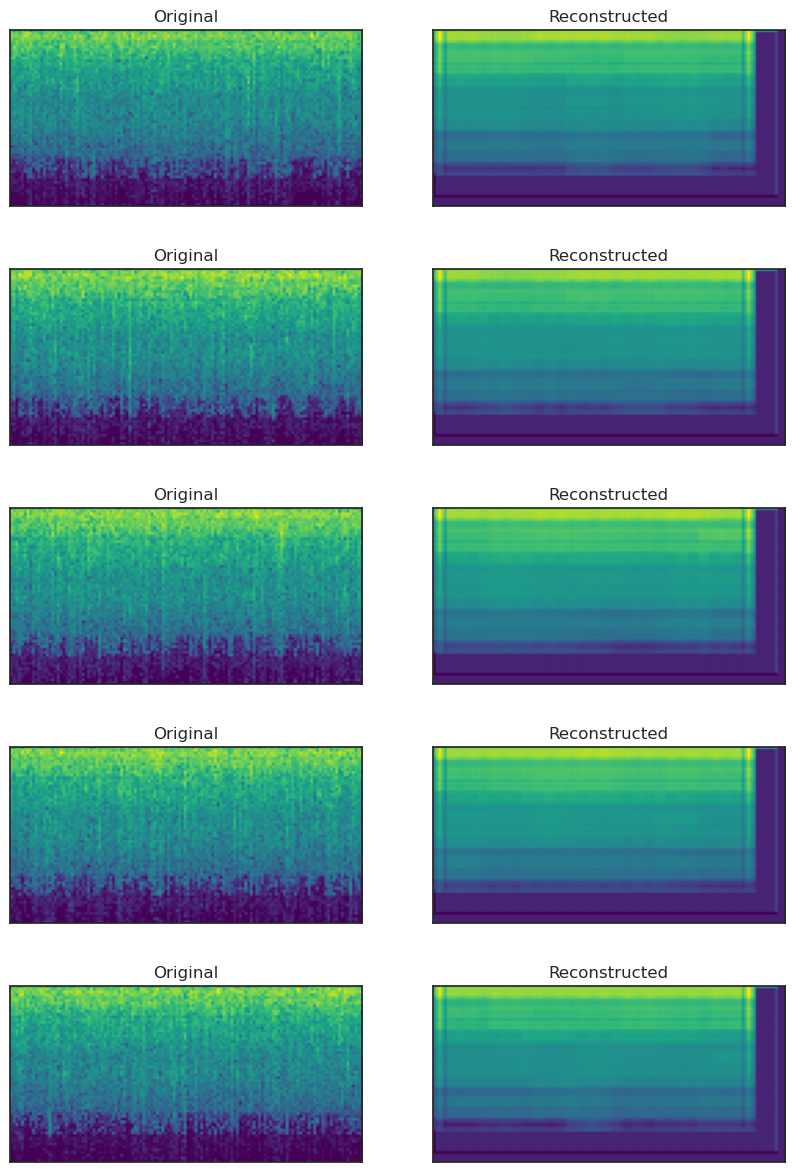

In [43]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

Since there's less variability in the audio from unlabelled dataset we evaluate the autoencoder reconstruction on the labelled dataset.

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.


2023-08-28 04:02:06.073807: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:06.078261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:06.079169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:06.082944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:06.083934: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:06.087085: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:06.090804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:06.091713: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:06.093341: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:06

Model: "Fully_Convolutional_AE_STFT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 3, 7, 6)           8734      
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        8709      
                                                                 
Total params: 17,443
Trainable params: 16,917
Non-trainable params: 526
_________________________________________________________________


2023-08-28 04:02:11.661070: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:11.662225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:11.665379: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:11.693684: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:11.696477: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:11.698969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:11.701761: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:11.704490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:11.707280: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:11

1/1 [==============================] - 0s 129ms/step


2023-08-28 04:02:12.056360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.070055: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.079862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.088977: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.095776: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.100651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.205145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.244944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.256767: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


1/1 [==============================] - 0s 17ms/step


2023-08-28 04:02:12.263837: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.275518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.283696: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.288514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.319451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.330487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.338151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.345366: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.351102: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12

1/1 [==============================] - 0s 18ms/step


2023-08-28 04:02:12.464232: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.470108: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-08-28 04:02:12.473722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


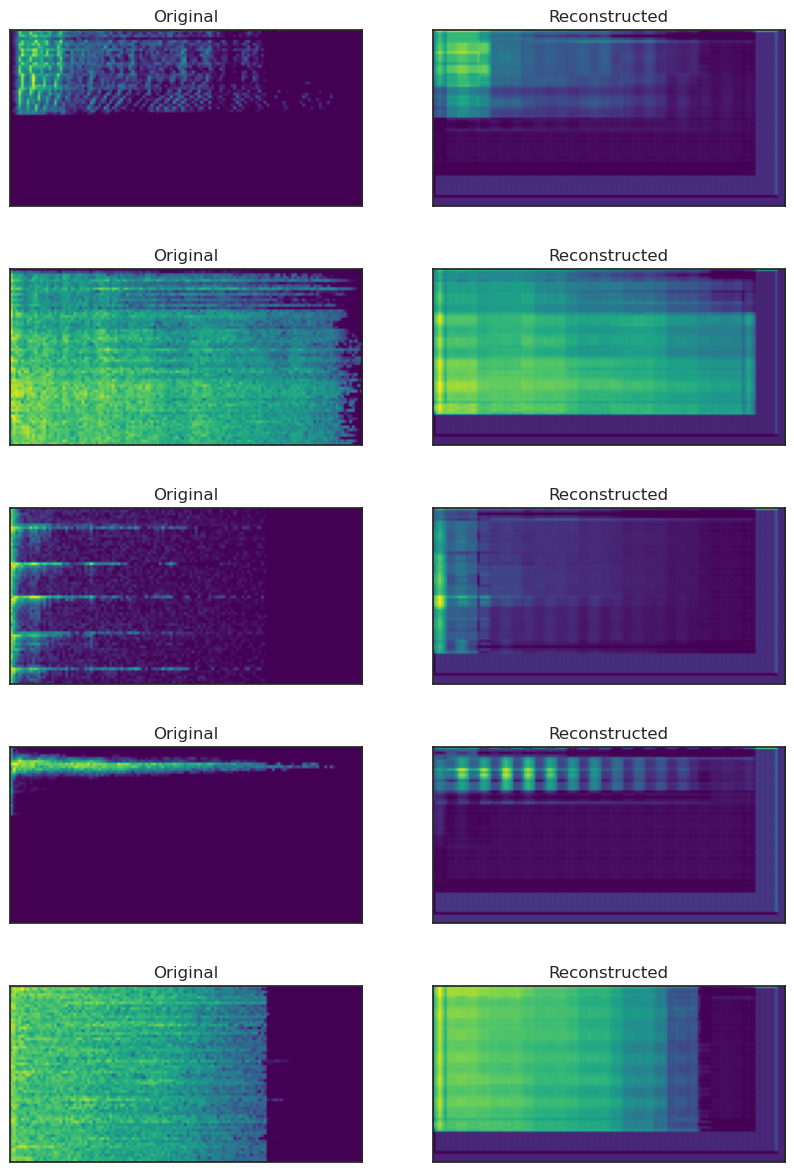

In [44]:

train, val, test, label_names = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = 30,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT" or "MFCC"
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()
# show n original and reconstructed images
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)